In [1]:
import ssms
import lanfactory 
import os
import numpy as np
from copy import deepcopy
import torch

In [3]:
MODEL = 'angle'
RUN_SIMS = False

In [4]:
# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config['lan'])
# Specify generative model (one from the list of included models mentioned above)
generator_config['dgp_list'] = MODEL
# Specify number of parameter sets to simulate
generator_config['n_parameter_sets'] = 256
# Specify how many samples a simulation run should entail
generator_config['n_samples'] = 2000
# Specify folder in which to save generated data
generator_config['output_folder'] = 'data/lan_mlp/'

# Make model config dict
model_config = ssms.config.model_config[MODEL]

In [5]:
model_config

{'name': 'angle',
 'params': ['v', 'a', 'z', 't', 'theta'],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.001, -0.1], [3.0, 3.0, 0.9, 2.0, 1.3]],
 'boundary': <function ssms.basic_simulators.boundary_functions.angle(t=1, theta=1)>,
 'n_params': 5,
 'default_params': [0.0, 1.0, 0.5, 0.001, 0.0],
 'hddm_include': ['z', 'theta'],
 'nchoices': 2}

In [7]:
generator_config['output_folder'] = 'data/lan_mlp/' + generator_config['dgp_list'] + '/' + \
                                    str(generator_config['n_samples']) + '_' + \
                                        str(generator_config['n_training_samples_by_parameter_set']) + '/'


In [8]:
if RUN_SIMS:
    n_datafiles = 20
    for i in range(n_datafiles):
        print('Datafile: ', i)
        my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(generator_config = generator_config,
                                                                              model_config = model_config)
        training_data = my_dataset_generator.generate_data_training_uniform(save = True)

In [9]:
import pickle
my_data = pickle.load(open('data/lan_mlp/angle/2000_1000/training_data_8d617928653811eebb25a0423f3e9be0.pickle' , 'rb'))

In [12]:
my_data['labels']

array([ -1.68907  ,  -1.2301161,  -1.247614 , ..., -66.77497  ,
       -66.77497  , -66.77497  ], dtype=float32)

In [13]:
network_config = lanfactory.config.network_configs.network_config_mlp

print('Network config: ')
print(network_config)

train_config = lanfactory.config.network_configs.train_config_mlp

print('Train config: ')
print(train_config)

Network config: 
{'layer_sizes': [100, 100, 1], 'activations': ['tanh', 'tanh', 'linear'], 'train_output_type': 'logprob'}
Train config: 
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 0.002, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': True}


In [14]:
train_config['cpu_batch_size'] = 128
train_config['gpu_batch_size'] = 2048
train_config['n_epochs'] = 20

In [16]:
folder_ = 'data/lan_mlp/' + MODEL + '/2000_1000/'
file_list_ = [folder_ + file_ for file_ in os.listdir(folder_)]

# Training dataset
torch_training_dataset = lanfactory.trainers.DatasetTorch(file_ids = file_list_,
                                                          batch_size = train_config['gpu_batch_size'] if \
                                                                            torch.cuda.is_available() else train_config['cpu_batch_size'],
                                                          label_lower_bound = np.log(1e-10),
                                                          features_key='data',
                                                          label_key='labels',
                                                          out_framework='torch',
                                                          )

torch_training_dataloader = torch.utils.data.DataLoader(torch_training_dataset,
                                                        shuffle = True,
                                                        batch_size = None,
                                                        num_workers = 1,
                                                        pin_memory = True)

# Validation dataset
torch_validation_dataset = lanfactory.trainers.DatasetTorch(file_ids = file_list_,
                                                            batch_size = train_config['gpu_batch_size'] if \
                                                                            torch.cuda.is_available() else train_config['cpu_batch_size'],
                                                            
                                                            label_lower_bound = np.log(1e-10),
                                                            features_key='data',
                                                            label_key='labels',
                                                            out_framework='torch',)

torch_validation_dataloader = torch.utils.data.DataLoader(torch_validation_dataset,
                                                          shuffle = True,
                                                          batch_size = None,
                                                          num_workers = 1,
                                                          pin_memory = True)

In [17]:
cnt = 0 
for xb, yb in torch_training_dataloader:
    print(xb)
    print(yb)
    cnt += 1
    if cnt > 0:
        break

tensor([[-0.2859,  1.5254,  0.8971,  ...,  0.8694,  1.4443,  1.0000],
        [ 2.3546,  2.7225,  0.1075,  ...,  0.6222,  1.7985,  1.0000],
        [ 2.5058,  2.0068,  0.3409,  ...,  0.6053,  1.3691,  1.0000],
        ...,
        [ 2.7323,  1.6003,  0.4028,  ...,  0.6330,  2.3316,  1.0000],
        [ 2.2446,  2.0103,  0.3365,  ...,  0.8664,  2.3509,  1.0000],
        [-0.2184,  1.0581,  0.4081,  ...,  0.0791,  6.5410,  1.0000]])
tensor([[-1.3090],
        [-0.0718],
        [ 0.3968],
        ...,
        [-1.5956],
        [ 0.5722],
        [-8.6107]])


In [19]:
# LOAD NETWORK
net = lanfactory.trainers.TorchMLP(network_config = deepcopy(network_config),
                                   input_shape = torch_training_dataset.input_dim)

# SAVE CONFIGS
lanfactory.utils.save_configs(model_id = MODEL + '_torch',
                              save_folder = 'data/torch_models/' + MODEL + '/', 
                              network_config = network_config, 
                              train_config = train_config, 
                              allow_abs_path_folder_generation = True)

tanh
tanh
linear
Found folder:  data
Moving on...
Found folder:  data/torch_models
Moving on...
Found folder:  data/torch_models/angle
Moving on...
Saved network config
Saved train config


In [20]:
model_trainer = lanfactory.trainers.ModelTrainerTorchMLP(train_config = 'data/torch_models/angle/angle_torch_train_config.pickle',
                                                         model = net,
                                                         train_dl = torch_training_dataloader,
                                                         valid_dl = torch_validation_dataloader,
                                                         allow_abs_path_folder_generation = False,
                                                         pin_memory = True,
                                                         seed = None)

Torch Device:  cuda
train_config is passed as string:  data/torch_models/angle/angle_torch_train_config.pickle
Trying to load string as path to pickle file: 
{'cpu_batch_size': 128, 'gpu_batch_size': 2048, 'n_epochs': 20, 'optimizer': 'adam', 'learning_rate': 0.002, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': True}


In [21]:
model_trainer.train_and_evaluate(output_folder = "data/trained_model/torch/",
                                 output_file_id = MODEL,
                                 run_id = 'test_run_notebook',
                                 wandb_on = True,
                                 wandb_project_id = 'test_run_notebook',
                                 save_data_details = True,
                                 verbose = 1,
                                 save_all = True)

Found folder:  data
Moving on...
Found folder:  data/trained_model
Moving on...
Found folder:  data/trained_model/torch
Moving on...


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: afengler. Use `wandb login --relogin` to force relogin


Succefully initialized wandb!
epoch: 0 / 20, batch: 0 / 2440, batch_loss: 4.694940567016602
epoch: 0 / 20, batch: 100 / 2440, batch_loss: 2.23306941986084
epoch: 0 / 20, batch: 200 / 2440, batch_loss: 0.9773080348968506
epoch: 0 / 20, batch: 300 / 2440, batch_loss: 0.7204380035400391
epoch: 0 / 20, batch: 400 / 2440, batch_loss: 0.5427260398864746
epoch: 0 / 20, batch: 500 / 2440, batch_loss: 0.5137326717376709
epoch: 0 / 20, batch: 600 / 2440, batch_loss: 0.456951379776001
epoch: 0 / 20, batch: 700 / 2440, batch_loss: 0.3506656289100647
epoch: 0 / 20, batch: 800 / 2440, batch_loss: 0.35916250944137573
epoch: 0 / 20, batch: 900 / 2440, batch_loss: 0.3065577745437622
epoch: 0 / 20, batch: 1000 / 2440, batch_loss: 0.26735538244247437
epoch: 0 / 20, batch: 1100 / 2440, batch_loss: 0.27880311012268066
epoch: 0 / 20, batch: 1200 / 2440, batch_loss: 0.26584047079086304
epoch: 0 / 20, batch: 1300 / 2440, batch_loss: 0.22467461228370667
epoch: 0 / 20, batch: 1400 / 2440, batch_loss: 0.23233294

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


loss,█▅▃▃▃▂▃▂▂▃▂▄▂▂▂▂▁▂▂▂
val_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
loss,0.02958
val_loss,0.03005


wandb uploaded
Training finished successfully...


In [24]:
# Load Network:
infer_net = lanfactory.trainers.LoadTorchMLPInfer(model_file_path = 'data/trained_model/torch/angle_lan_test_run_notebook_train_state_dict_torch.pt',
                                      network_config = 'data/torch_models/angle/angle_torch_network_config.pickle',
                                      input_dim = model_config['n_params'] + 2)

tanh
tanh
linear


In [61]:
# Test parameters:
v, a, z, t, theta = 0.5, 1.5, 0.5, 0.3, 0.3

# Comparison simulator run
sim_out = ssms.basic_simulators.simulator.simulator(model = MODEL, 
                                          theta = [v,a,z,t,theta],
                                          n_samples = 50000)

# Make input matric
input_mat = torch.zeros(2000, 7)
input_mat[:, 0] = torch.ones(2000) * v
input_mat[:, 1] = torch.ones(2000) * a
input_mat[:, 2] = torch.ones(2000) * z
input_mat[:, 3] = torch.ones(2000) * t
input_mat[:, 4] = torch.ones(2000) * theta
input_mat[:, 5] = torch.tensor(np.concatenate([np.linspace(5, 0, 1000).astype(np.float32),
                                              np.linspace(0, 5, 1000).astype(np.float32)]))
input_mat[:, 6] = torch.tensor(np.concatenate([np.repeat(-1., 1000), np.repeat(1., 1000)]).astype(np.float32))

net_out = infer_net(input_mat.cuda())

(array([6.06134177e-04, 9.69814683e-04, 3.27312455e-03, 4.72784658e-03,
        1.07891883e-02, 1.95175205e-02, 2.54576354e-02, 3.51557822e-02,
        4.15808045e-02, 5.27336734e-02, 6.76445741e-02, 7.46757306e-02,
        8.82531361e-02, 1.00860727e-01, 1.14801813e-01, 1.20378247e-01,
        1.32137251e-01, 1.46320790e-01, 1.48139193e-01, 1.34440560e-01,
        9.64965609e-02, 2.44878207e-02, 1.21226835e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.15808045e-02,
        2.90217044e-01, 5.02000325e-01, 5.30124951e-01, 5.14486689e-01,
        4.83937527e-01, 4.26476007e-01, 3.70105528e-01, 3.11916647e-01,
        2.64153274e-01, 2.16996035e-01, 1.75900138e-01, 1.41714170e-01,
        1.19408433e-01, 7.79488551e-02, 5.66129321e-02, 3.97624020e-02,
        2.65486769e-02, 1.39410861e-02, 7.87974430e-03, 3.75803190e-03,
        1.69717569e-03, 6.06134177e-04]),
 array([-4.07246923, -3.90748926, -3.74250929, -3.57752932, -3.41254934,
        -3.24756937, 

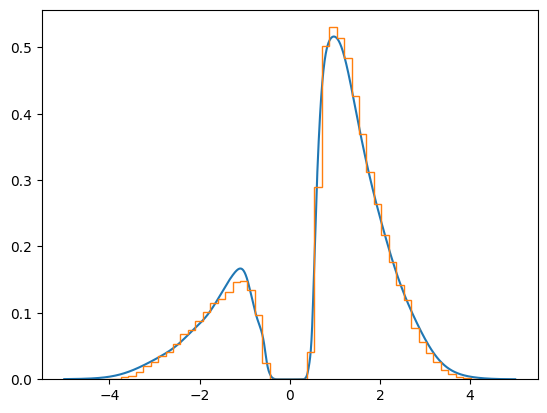

In [70]:
from matplotlib import pyplot as plt
plt.plot(np.linspace(-5, 5, 2000).astype(np.float32), 
         np.exp(net_out.cpu()))

plt.hist(sim_out['rts'] * sim_out['choices'], bins = 50, histtype = 'step', fill = None, density = True)